In [69]:
import pandas as pd

import util
import geopandas as gpd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate

import statsmodels.api as sm
import timeit
import contextily as cx
import datatable as dt
import seaborn as sns

import matplotlib.pyplot as plt

In [11]:
# file paths
det_str = 'data/output/detectors_mean_3857.gpkg'
parks_str = 'data/gdf_parkingspots_clean.gpkg'

In [12]:
det = gpd.read_file(det_str, engine='pyogrio')

In [13]:
park = gpd.read_file(parks_str, engine='pyogrio')

In [14]:
det.to_crs(3857, inplace=True)
park.to_crs(3857, inplace = True)

In [15]:
park.city

0        paris, France
1        paris, France
2        paris, France
3        paris, France
4        paris, France
             ...      
55914       london, UK
55915       london, UK
55916       london, UK
55917       london, UK
55918       london, UK
Name: city, Length: 55919, dtype: object

In [21]:
park.city = park['city'].apply(lambda x: x.split(', ')[0])

In [28]:
park.city.unique()

array(['paris', 'toronto', 'melbourne', 'hamburg', 'london'], dtype=object)

In [29]:
park.head()

,city,underground_p_num,surface_p_num,multi_store_p_num,lane_p_num,street_side_p_num,geometry
0,paris,1.0,0.0,0.0,0.0,0.0,POINT (262236.783 6253816.786)
1,paris,1.0,0.0,0.0,0.0,0.0,POINT (261978.343 6253345.552)
2,paris,1.0,0.0,0.0,0.0,0.0,POINT (261568.944 6250623.246)
3,paris,1.0,0.0,0.0,0.0,0.0,POINT (260022.482 6249808.127)
4,paris,1.0,0.0,0.0,0.0,0.0,POINT (260879.965 6249933.065)


In [22]:

det.rename(columns={'citycode': 'city'}, inplace=True)

park_g = park.groupby('city')
det_g = det.groupby('city')

In [31]:
det.head()

,detid,length,pos,fclass,road,limit,city,lanes,linkid,interval,mean_flow,std_flow,count_flow,geometry
0,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,0,62.1875,37.540711,192,POINT (1212219.462 6166949.144)
1,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,1,47.5625,36.640839,192,POINT (1212219.462 6166949.144)
2,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,2,37.5625,35.267360,192,POINT (1212219.462 6166949.144)
3,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,3,34.6875,31.057222,192,POINT (1212219.462 6166949.144)
4,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,4,39.9375,23.710211,192,POINT (1212219.462 6166949.144)


In [32]:
park.head()

,city,underground_p_num,surface_p_num,multi_store_p_num,lane_p_num,street_side_p_num,geometry
0,paris,1.0,0.0,0.0,0.0,0.0,POINT (262236.783 6253816.786)
1,paris,1.0,0.0,0.0,0.0,0.0,POINT (261978.343 6253345.552)
2,paris,1.0,0.0,0.0,0.0,0.0,POINT (261568.944 6250623.246)
3,paris,1.0,0.0,0.0,0.0,0.0,POINT (260022.482 6249808.127)
4,paris,1.0,0.0,0.0,0.0,0.0,POINT (260879.965 6249933.065)


It is too computationally expensive to calculate all the distances dj to pi therefore we choose 100 random parking spots and look at that.

Goal is to explort the distribution of the distances and find for every city a reasonable distance. Do no run this cell light hardly.

<Axes: >

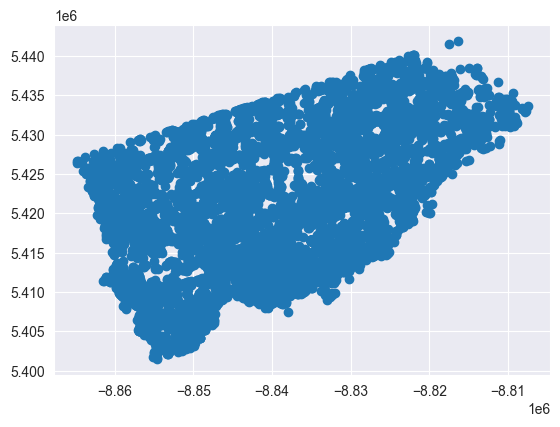

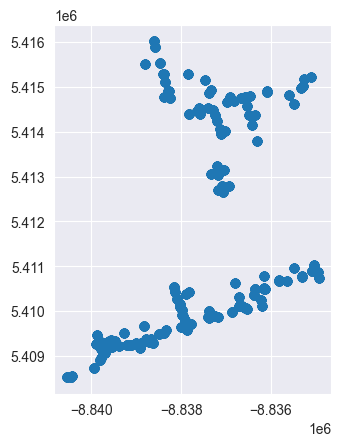

In [33]:
park_g.get_group('toronto').plot()
det_g.get_group('toronto').plot()

In [34]:
park.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
det.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Distance study

In this code pice i study the effect of difference distance methods on the distribution of parking spots (see vis next one). The method circumvent the aggregation of the distances between sampled detectors to sampled parking spots. Goal is to have a consitent method for threshold determination for all cities.


* method 1: mean. Interpretation: The average distance to a parking spot
* method 2: 1% quantile. The 1% lowest distance values for a parking spot. can be interpreted as 1 of 100 parking spots is in the distance of the detector
* method 3: min. min distance from detector to parking spo

In [23]:
cit_dist_mean = {}
cit_dist_quant = {}
cit_dist_min = {}

for city in park['city'].unique():
    park_int = park_g.get_group(city)['geometry'].sample(1000)
    det_int = det_g.get_group(city)['geometry'].sample(200)

    #sample_p = np.random.choice(park_int,100)
    #sample_d = np.random.choice(det_int,1000)
    cit_dist_mean[city] = [np.mean([d.distance(p) for p in park_int]) for d in det_int]

    cit_dist_quant[city] = [np.quantile([d.distance(p) for p in park_int], .01) for d in det_int]

    cit_dist_min[city] = [np.min([d.distance(p) for p in park_int]) for d in det_int]

    print(city)


paris
toronto
melbourne
hamburg
london


Study the distribution of the distances for every city and the different approaches.


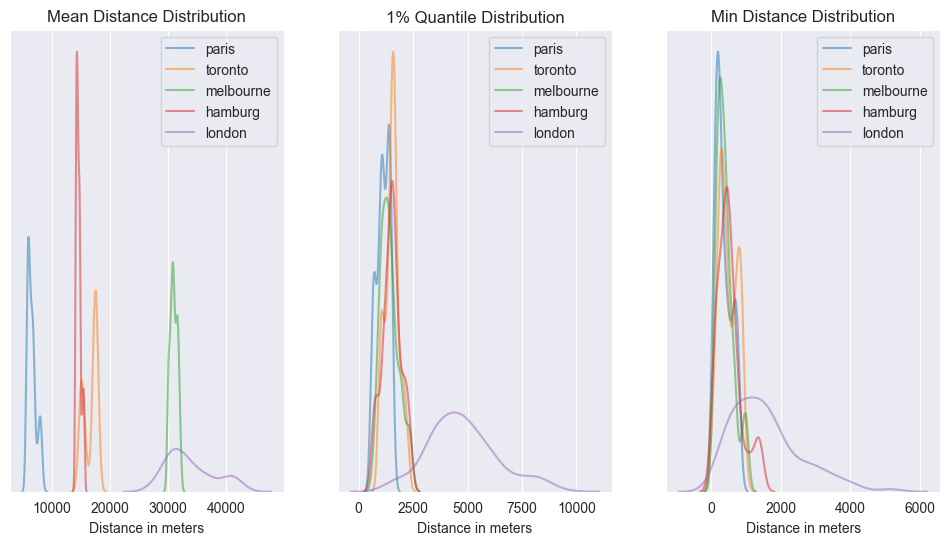

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 3, figsize=(12, 6))

for c in cit_dist_mean.keys():
    # Plot KDE
    kde_plot_mean = sns.kdeplot(cit_dist_mean[c], label=c, legend=True, ax=ax[0], alpha=.5)
    kde_plot_quant = sns.kdeplot(cit_dist_quant[c], label=c, legend=True, ax=ax[1], alpha=.5)
    kde_plot_min = sns.kdeplot(cit_dist_min[c], label=c, legend=True, ax=ax[2], alpha=.5)


    # Extract color from KDE plot
    #color_mean = kde_plot_mean.lines[-1].get_color()
    #color_quant = kde_plot_quant.lines[-1].get_color()

    # Add vertical lines to highlight the mean values with the same color as KDE plot
    #ax[0].axvline(x=np.mean(cit_dist_mean[c]), color=color_mean, linestyle='-', linewidth=2, alpha=.8)
    #ax[1].axvline(x=np.mean(cit_dist_quant[c]), color=color_quant, linestyle='-', linewidth=2, alpha=.8)
    #ax[2].axvline(x=np.mean(cit_dist_min[c]), color=color_quant, linestyle='-', linewidth=2, alpha=.8)

ax[0].legend()
ax[1].legend()
ax[2].legend()

# Remove y-axis
ax[0].yaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[2].yaxis.set_visible(False)

# Set x-axis labels and titles
ax[0].set_xlabel('Distance in meters')
ax[1].set_xlabel('Distance in meters')
ax[0].set_title('Mean Distance Distribution')
ax[1].set_title('1% Quantile Distribution')
ax[2].set_xlabel('Distance in meters')
ax[2].set_title('Min Distance Distribution')
plt.savefig('fig/distance_kde_detecs.png')
plt.show()



Interpretation:

* for all city besides london 1 of 100 detectors is connected within a distance of smaller 2000
* Therefore I would adjust the radius around a parking spot according to this threshold. The mean of the 1% distribution.
* *further description by editor needed*


Next step:
* only the 1% and the min approach make sense to implement. Otherwise to much buffer overlap between detectors
* Calculate per city for al the detecs the mean... this means the threshold per city is the average threshold for the cities.

In [24]:
# Convert dictionary to list of dictionaries -> a key is regardes as a column in adf... nice to know :)
quant = [{'city': city, 'Values': values} for city, values in cit_dist_quant.items()]
min = [{'city': city, 'Values': values} for city, values in cit_dist_min.items()]
# Convert list of dictionaries to DataFrame
thres_min = pd.DataFrame(min)
thres_quant = pd.DataFrame(quant)



thres_min= thres_min.set_index('city').apply(lambda row: np.mean(row['Values']), axis=1).rename('min')
thres_quant = thres_quant.set_index('city').apply(lambda row: np.mean(row['Values']), axis=1).rename('1_g')


thres = pd.concat([thres_min, thres_quant], axis=1).unstack().reset_index().set_index('city').rename(columns={'level_0':'approach', 0: 'threshold'})

thres

,approach,threshold
city,,
paris,min,317.102214
toronto,min,281.242905
melbourne,min,339.945418
hamburg,min,395.629071
london,min,1233.545067
paris,1_g,1091.816418
toronto,1_g,1202.410967
melbourne,1_g,1298.321072
hamburg,1_g,1616.213057


<Axes: >

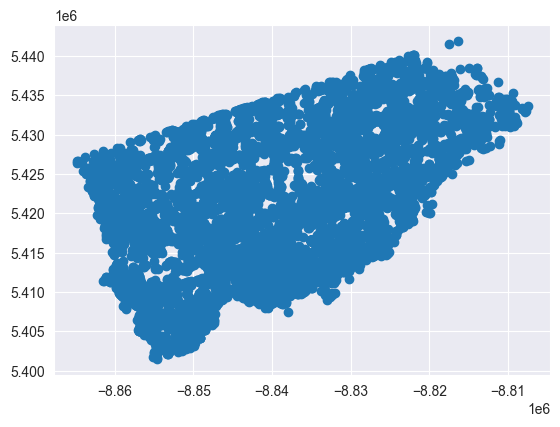

In [39]:
park[park.city=='toronto'].plot()

In [40]:
park[park.city=='toronto'].buffer(1000).head()

1386    POLYGON ((-8836098.355 5411910.767, -8836103.1...
1387    POLYGON ((-8837438.765 5411745.989, -8837443.5...
1388    POLYGON ((-8836098.278 5411581.938, -8836103.0...
1389    POLYGON ((-8836046.625 5411730.050, -8836051.4...
1390    POLYGON ((-8837952.003 5413572.494, -8837956.8...
dtype: geometry

In [41]:
det.columns

Index(['detid', 'length', 'pos', 'fclass', 'road', 'limit', 'city', 'lanes',
       'linkid', 'interval', 'mean_flow', 'std_flow', 'count_flow',
       'geometry'],
      dtype='object')

In [25]:
# Preparing the det data frame

hours_int = list(np.arange(7,19))
det_trans = det[det.interval.isin(hours_int)].groupby(['city','detid'])['mean_flow'].mean().reset_index()
det_join = det_trans.merge(det[['city','detid', 'geometry']], on =['city','detid'], how='inner').drop_duplicates(['detid', 'city'], keep= 'first')
det_joinGeo = gpd.GeoDataFrame(det_join, geometry='geometry', crs=3857)

In [26]:
det_joinGeo.groupby('city').get_group('paris').shape#208

(208, 4)

### Control variable = pop density


Adding control variable pop density from [LINK](https://data.humdata.org/dataset/tuvalu-high-resolution-population-density-maps-demographic-estimates)

Method:

To create our high-resolution maps, we use machine learning techniques to identify buildings from commercially available satellite images. Then we work with our partners at Columbia University to overlay general population estimates based on publicly available census data and other population statistics. The resulting maps are the most detailed and actionable tools available for aid and research organizations. For more information about the methodology used to create our high resolution population density maps and the demographic distributions, please visit: https://dataforgood.fb.com/docs/methodology-high-resolution-population-density-maps-demographic-estimates/

Variable = population density
unit = people / 900m2 (resolution 30m)

data for CN not accessible... Regression and stuff must take account for this. if toronot etc.

In [1]:
pop_strings= {'paris': 'data/population_fra_2019-07-01.csv',
              'hamburg': 'data/population_deu_2019-07-01.csv',
              'melbourne': 'data/population_aus_2018-10-01.csv',
                'london': 'data/population_gbr_2019-07-01.csv'
              }

In [8]:
dfs = {}


for key, value in pop_strings.items():
    dt_df = dt.fread(value)
    pop_pre  = dt_df.to_pandas()

    if 'population_2015' in pop_pre.columns:
        pop_pre = pop_pre.drop('population_2015', axis=1)

    pop_pre.columns = ['latitude', 'longitude', 'pop_dens']

    pop_pre['city'] = key

    geometry = gpd.points_from_xy(pop_pre['longitude'], pop_pre['latitude'])

    pop = gpd.GeoDataFrame(pop_pre, geometry=geometry, crs=4326)

    pop_meter = pop.to_crs(3857)

    pop_meter = pop_meter.drop(['longitude', 'latitude'], axis=1)

    dfs[key] = pop_meter

    print(f'done_{key}')


done_paris
done_hamburg
done_melbourne
done_london


In [32]:
dfs['paris'].columns

Index(['pop_dens', 'city', 'geometry'], dtype='object')

In [33]:
def spat_join(parking, detecs, pop, thresholds):
    '''

    :param parking: pandas df object with the parking spots
    :param detecs:  pandas df object with the detectors
    :param thresholds: pandas df object with the thresholds
    :return: list of dfs for every city mapping parkingspots to detectors and sum the number. individual df per city.
    '''
    dfs ={}

    cities = list(parking.city.unique())

    park_vars = list(parking.columns[1:-1])

    park_g = parking.groupby('city')

    detecs_g = detecs.groupby('city')

    for c in cities:
        parking_c = park_g.get_group(c)

        detecs_c = detecs_g.get_group(c)

        thres_c = thresholds.groupby('approach').get_group('min').loc[c, 'threshold']

        detecs_int = detecs_c[['detid', 'geometry']]

        detecs_int['geometry'] = detecs_c.buffer(thres_c)

        if c != 'toronto':
            # first popoulation

            # join the population to the detectors
            join_pop = detecs_int.sjoin(pop[c], how='left')

            # Aggregate it. Overwirte detect_c
            ag_pop = join_pop.groupby(['detid'])['pop_dens'].mean().reset_index()

            # join th parking spots tho detecs c
            join = gpd.sjoin(detecs_int, parking_c, how='left', op='intersects')
            # aggregate via sum
            ag = join.groupby(['detid'])[park_vars].sum().reset_index()


            dfs[c] = detecs_c.merge(ag, on=['detid'], how='inner').merge(ag_pop[['detid', 'pop_dens']], on=['detid'], how='inner')

        else:
            join = gpd.sjoin(detecs_int, parking_c, how='left', op='intersects')
            # aggregate via sum
            ag = join.groupby(['detid'])[park_vars].sum().reset_index()


            dfs[c] = detecs_c.merge(ag, on=['detid'], how='inner')

        print(f'{c} done')

    return dfs


In [76]:
df_cit = spat_join(park, det_joinGeo, dfs,  thres)

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

paris done
toronto done


C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

melbourne done


C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


hamburg done


C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


london done


### doing some EDA

In [79]:
df_cit['paris'].columns

Index(['city', 'detid', 'mean_flow', 'geometry', 'underground_p_num',
       'surface_p_num', 'multi_store_p_num', 'lane_p_num', 'street_side_p_num',
       'pop_dens'],
      dtype='object')

In [73]:
# why is it alot more?
for c in df_cit.keys():
    #print(df_cit[c][df_cit[c]['detid'].duplicated()].size)

    df_cit[c] = c
    print(df_cit[c].columns)

# where do this detecs come from?


AttributeError: 'str' object has no attribute 'columns'

In [ ]:
det_joinGeo.groupby(['city'])['detid'].unique().apply(len)


In [66]:
var_reg = list(park.columns[1:-1])+['mean_flow', 'pop_dens']


In [67]:
var_reg

['underground_p_num',
 'surface_p_num',
 'multi_store_p_num',
 'lane_p_num',
 'street_side_p_num',
 'mean_flow',
 'pop_dens']

In [80]:
df_cit['toronto']['pop_dens'] = np.NaN

In [81]:
# Assuming df_cit, var_reg, and 'city' are defined
df_plot = pd.concat([df for df in df_cit.values()], axis=0)

In [82]:
df_plot.columns

Index(['city', 'detid', 'mean_flow', 'geometry', 'underground_p_num',
       'surface_p_num', 'multi_store_p_num', 'lane_p_num', 'street_side_p_num',
       'pop_dens'],
      dtype='object')

In [94]:
print(df_plot.groupby('city')['pop_dens'].mean())

city
hamburg       6.456178
london       14.760146
melbourne    14.846994
paris        28.118723
toronto            NaN
Name: pop_dens, dtype: float64


somehow not possible .. try later to trouble shoot


KeyboardInterrupt: 

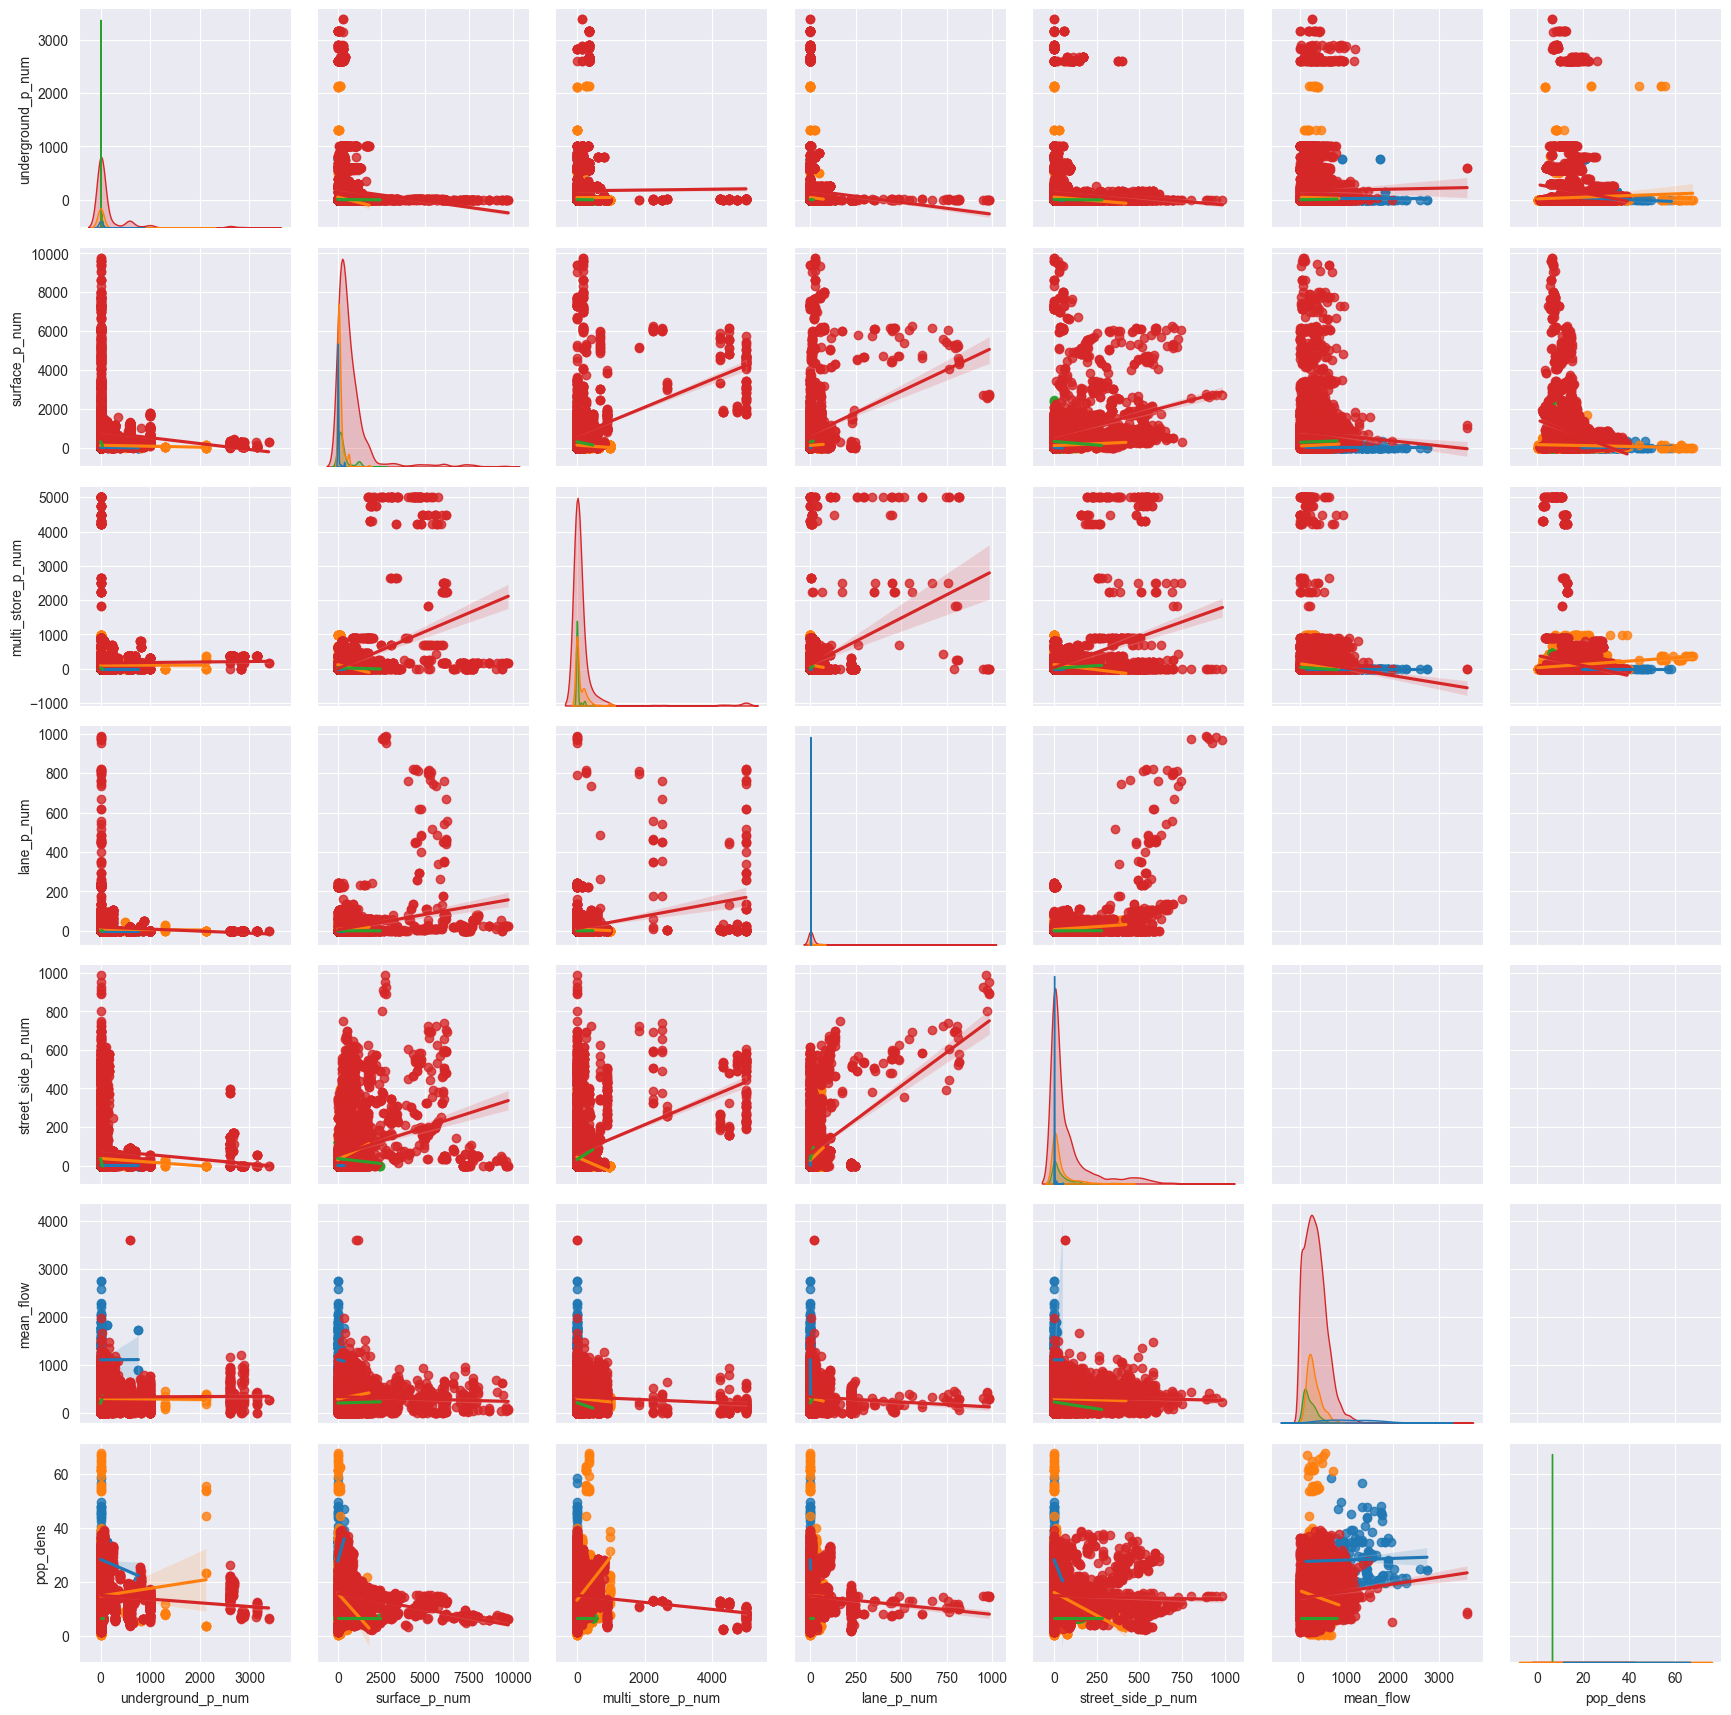

In [83]:
# Plot the pairplot for the filtered DataFrame
sns.pairplot(df_plot, vars=var_reg, hue='city', kind='reg')
plt.savefig('fig\pairpl_min_assump_exclTor.png')
plt.show()

Correlation plot:
WHY: Get an understanding what variables are how correlated with the mean traffic flow


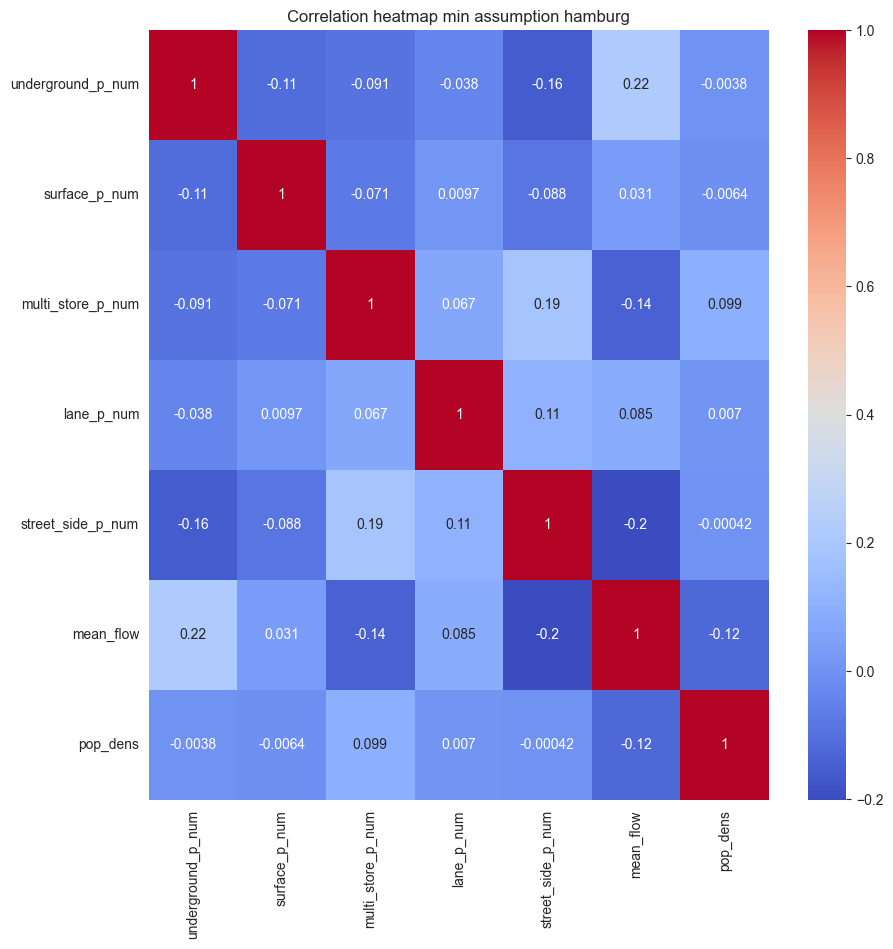

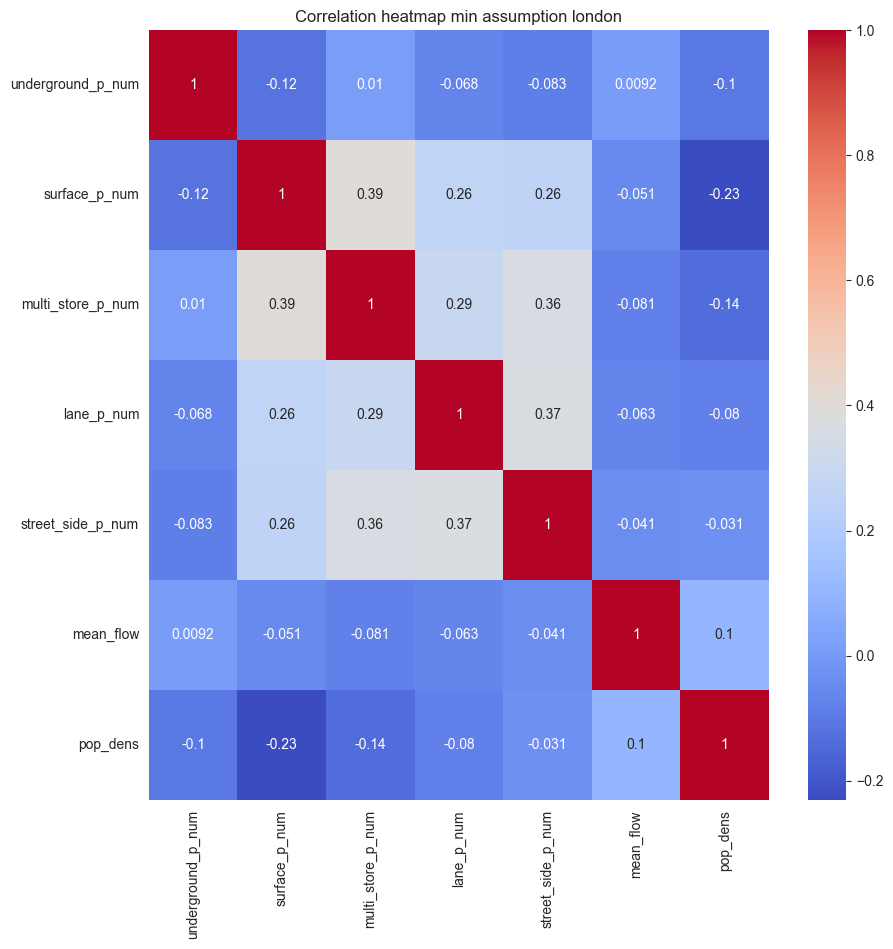

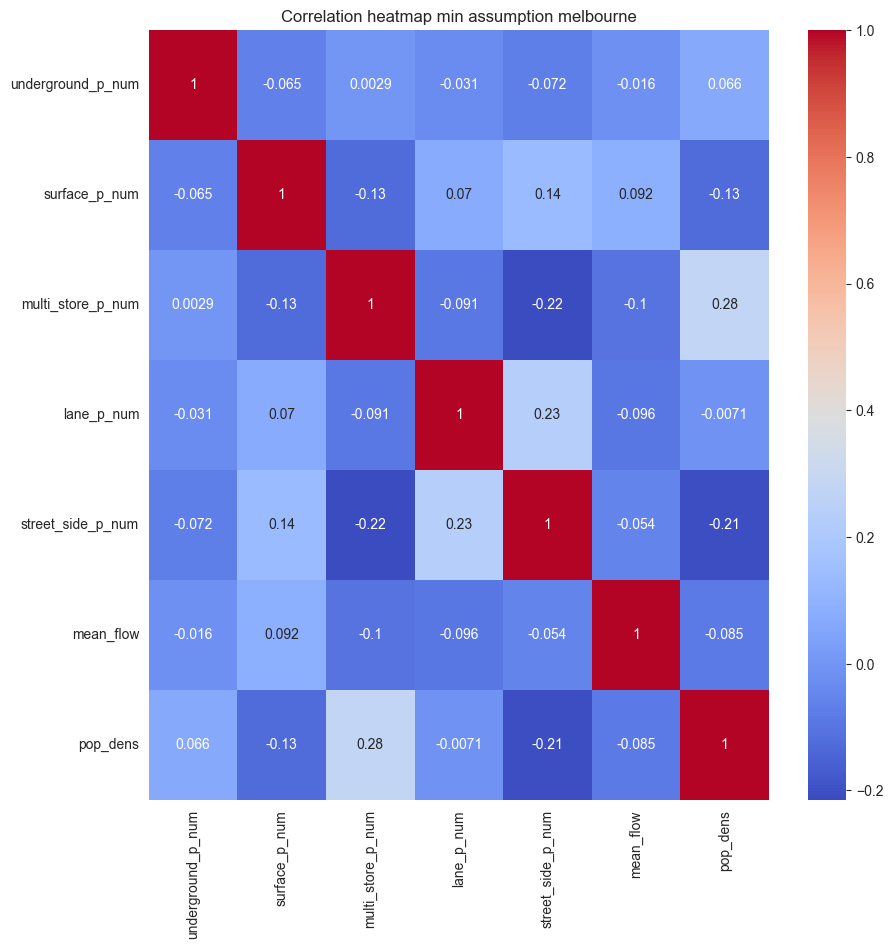

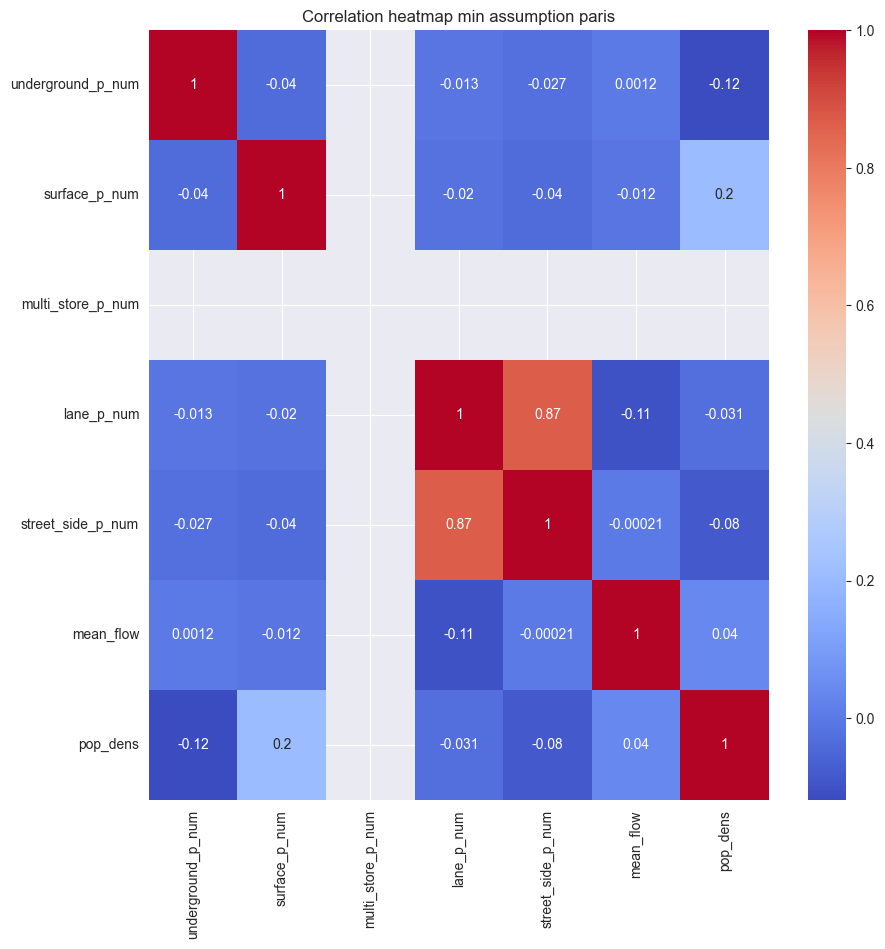

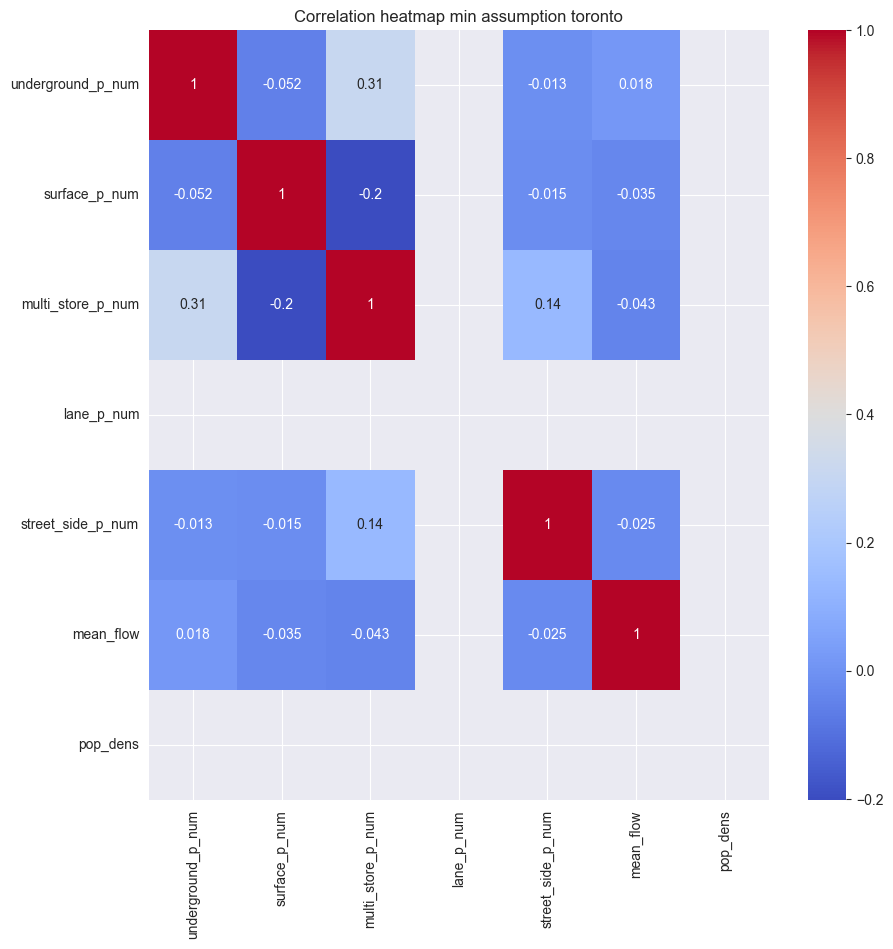

In [95]:
for c, data in df_plot.groupby('city'):
    f, ax = plt.subplots(1, figsize=(10,10))
    sns.heatmap(data[var_reg].corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation heatmap min assumption {c}')
    plt.savefig(f'fig\heat_corr_min_{c}')

In [72]:
df_plot.columns

Index(['city', 'detid', 'mean_flow', 'geometry', 'underground_p_num',
       'surface_p_num', 'multi_store_p_num', 'lane_p_num', 'street_side_p_num',
       'pop_dens'],
      dtype='object')

#### Outlier investigation

We see already in the distribution of the pairplot that the parking spot data have massive outliers ... lets investigate this in more depth:

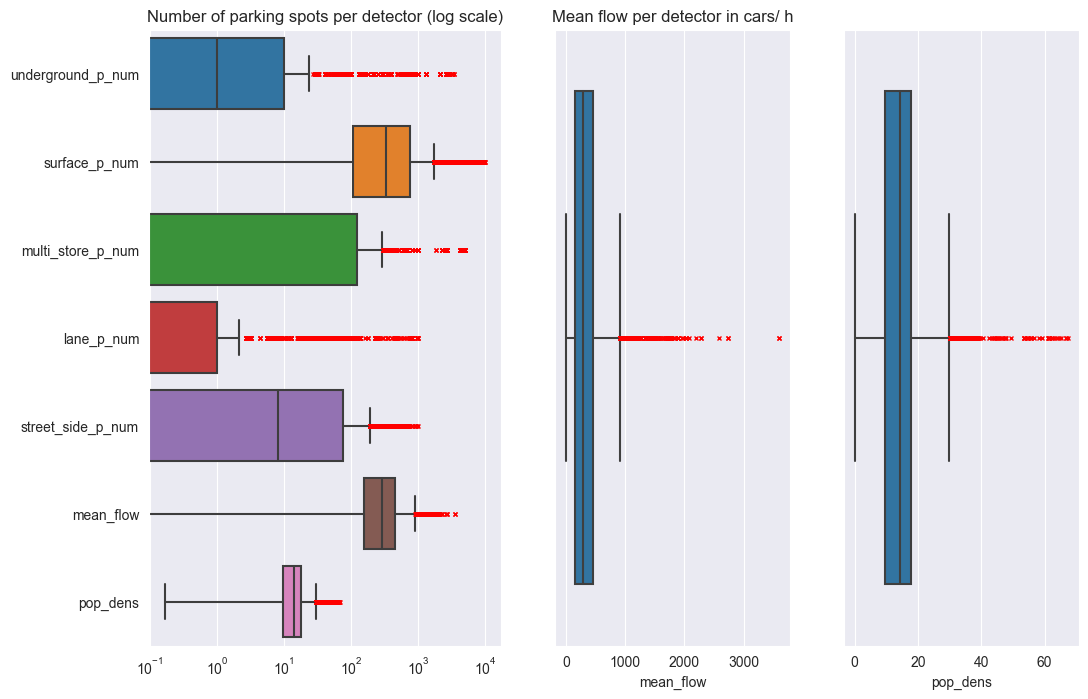

In [96]:
# Assuming df_plot and var_reg are defined
f, ax = plt.subplots(1, 3, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 2, 2]})

sns.boxplot(data=df_plot[var_reg], orient='h', fliersize=3, flierprops={'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red'}, ax=ax[0])
ax[0].set_xscale('log')  # Set x-axis to logarithmic scale
ax[0].set_title('Number of parking spots per detector (log scale)')

sns.boxplot(data=df_plot, x='mean_flow', orient='h', fliersize=3, flierprops={'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red'}, ax=ax[1])

sns.boxplot(data=df_plot, x='pop_dens', orient='h', fliersize=3, flierprops={'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red'}, ax=ax[2])

ax[1].set_title('Mean flow per detector in cars/ h')
plt.savefig('fig\par_det_box.png')
plt.show()


Conclusion:
* there are enormouse outliers with 3 orders of magnitude.
* Lets study the effect of this outliers.
* multi store p num and lane p num have an average value of 0  but outliers divergin by 3 orders of magnitude.

In [97]:
df_g = df_plot.groupby('city')
for c, data in df_g:
    print(f'Stats for city {c}')
    print(df_g.get_group(c).describe())

Stats for city hamburg
        mean_flow  underground_p_num  surface_p_num  multi_store_p_num   
count  418.000000         418.000000     418.000000         418.000000  \
mean   203.608963           2.395169     305.231345          24.556261   
std    131.658799           7.941079     391.795714          78.443542   
min     13.425021           0.000000       0.000000           0.000000   
25%    100.003776           0.000000      93.835574           0.000000   
50%    168.643199           0.000000     160.419315           0.000000   
75%    285.981375           0.000000     302.881997           0.000000   
max    800.385898          41.536211    2437.212675         472.811001   

       lane_p_num  street_side_p_num      pop_dens  
count  418.000000         418.000000  4.180000e+02  
mean     0.277081          33.468402  6.456178e+00  
std      1.379438          47.044045  3.166432e-16  
min      0.000000           0.000000  6.456178e+00  
25%      0.000000           0.000000  6.45617

We can verify:
* the number of underground_p_num is 0 on average with some very high outliers.
* in most cases the standard deviation is factor 2 higher then the mean which is tremendously high. and speaks for the falsification of our hypothesis.
* however first we should deal with the outliers. How do they behave with the traffic flow for the case of underground p num

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


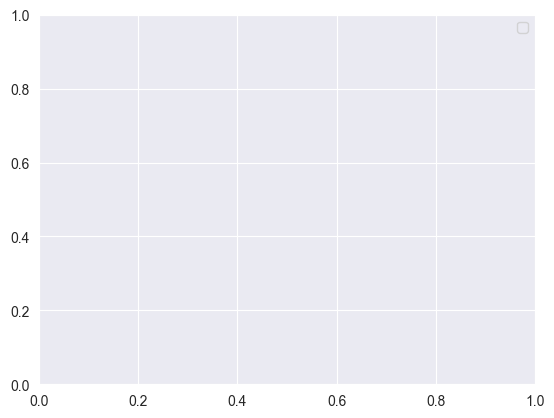

In [98]:
mask = (df_plot[var_reg] > df_plot[var_reg].quantile(0.75)).all(axis=1)
for v in var_reg:
    sns.scatterplot(df_plot[mask], x='mean_flow',y=v, label=v)
plt.legend()

* we see no significant trend in the outlier. They seem to be randomly distributed. For further analysis we drop the highest percent of values of the outliers for all the parking variables.
* the interpretation is that the outliers see also not dependent on the traffic flow

In [99]:
var_p = list(park.columns[1:-1])

In [100]:
mask = (df_plot[var_p] < df_plot[var_p].quantile(0.95)).all(axis=1)
df_reg = df_plot[mask]

In [103]:
df_reg.head()

,city,detid,mean_flow,geometry,underground_p_num,surface_p_num,multi_store_p_num,lane_p_num,street_side_p_num,pop_dens
0,paris,1,2201.658822,POINT (259838.725 6251132.622),0.000000,0.000000,0.0,0.000000,0.000000,21.423940
1,paris,10,1955.995182,POINT (261567.807 6250529.422),1.000000,0.000000,0.0,0.000000,0.000000,34.677258
2,paris,1053,290.494527,POINT (256818.351 6250071.984),0.000000,0.000000,0.0,1.472007,49.753213,24.654563
3,paris,11,1823.981741,POINT (261739.089 6250429.686),136.782798,36.178983,0.0,0.000000,0.000000,34.677258
5,paris,12,1823.981741,POINT (261925.151 6250317.953),136.782798,36.178983,0.0,0.000000,0.000000,34.677258


* well the long tailes could be significantly reduced.
* we shold think of dropping especially lane_p_num and multi store_p_num... the values consist almost only of 0 and outliers.

#### Next we do a short study on multicollinearity.
We study this phenomena city dependent, as the corr heatmaps showed a different behaviour for the city dependent variables.

Lets first safe the file not have to start from new :


In [ ]:
type(df_reg)

In [104]:
df_reg.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
df_reg.head()

All there. Lets export.

In [105]:
df_reg.to_file('data/output/data_reg.gpkg', engine='pyogrio')


### VIF calculation

WHY: The VIF is a nice indicator for collinearity (see explanation)
RULE of thumb: VIF >5 = collinearity


I use the variance inflation factor VFI to test for colinearity. It is a measure of how much the variance of the parameters of a model will increase (inflate) if a variable is added compared to the case where the variable is left out.The VIF provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [106]:
df_reg = gpd.read_file('data/output/data_reg.gpkg', engine='pyogrio')

In [107]:
df_reg.columns

Index(['city', 'detid', 'mean_flow', 'underground_p_num', 'surface_p_num',
       'multi_store_p_num', 'lane_p_num', 'street_side_p_num', 'pop_dens',
       'geometry'],
      dtype='object')

In [108]:
var_reg= ['multi_store_p_num', 'lane_p_num', 'street_side_p_num', 'surface_p_num', 'mean_flow', 'pop_dens']

In [112]:
def var_inf_calc(df, var):
    '''

    :param df: df with reg variables
    :param var: vars to do check for colinearity
    :return: df with index var and column city
    '''
    #if var not in df.columns:
    #    raise ValueError(f"{var} is not a column in df")

    collect ={}
    df_g = df.groupby('city')
    for c, data in df_g :
        if c != 'toronto':
            var_inf = [variance_inflation_factor(data[var], j) for j in range(data[var].shape[1])]
            collect[c] = var_inf

    sns.heatmap(pd.DataFrame(collect, index=var), annot=True, cmap='coolwarm')


In [110]:
var_reg

['multi_store_p_num',
 'lane_p_num',
 'street_side_p_num',
 'surface_p_num',
 'mean_flow',
 'pop_dens']

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


<Axes: >

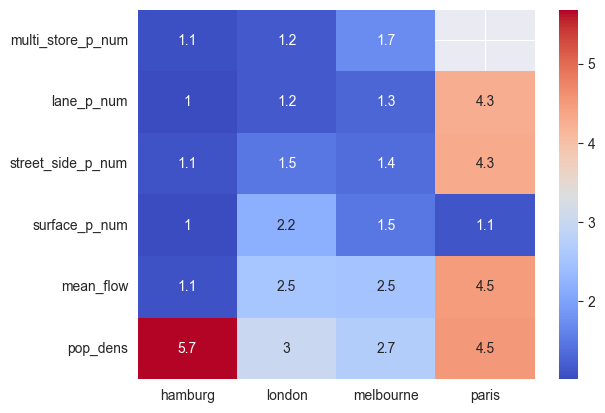

In [113]:
var_inf_calc(df_reg, var=var_reg)

Intrpretation:

* The square root of the variance inflation factor indicates how much larger the standard error increases compared to if that variable had 0 correlation to other predictor variables in the model.
* I apply the wikipedia criteria of >5 for colinearity meaning that the standard erro would be 5 times higher which is not the case for any of the vars.
* In general howver for paris we see the highest risk for colinearity between lane parking spots and street sid eparking spots.

Test for normality (gaussian) to identify if it reasonable to apply standardisation. I apply the  Shapiro-Wilk Test
Assumptions

    Observations in each sample are independent and identically distributed (iid).

Interpretation

    H0: the sample has a Gaussian distribution.
    H1: the sample does not have a Gaussian distribution


In [114]:
def normal_test (df, var):

    collect ={}
    df_g = df.groupby('city')
    for c, data in df_g:
        collect[c] =[]
        for v in var:
            collect[c] = [shapiro(data[v])[1] for v in var]


    return (pd.DataFrame(collect, index=var)>.05)

In [115]:
normal_test(df_reg,var_reg)

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,hamburg,london,melbourne,paris,toronto
multi_store_p_num,False,False,False,True,False
lane_p_num,False,False,False,False,True
street_side_p_num,False,False,False,False,False
surface_p_num,False,False,False,False,False
mean_flow,False,False,False,False,False
pop_dens,False,False,False,False,True


Result:
* only multi_store_p_num and lane_p_num for paris and lane_p_num are probably normal distributed. -> for all the other variables the H0 is not valid anymore. -> so a standardization is not recommendable
* Because we need to normalize we apply the min max scaler. we apply it to al vars.

#### Log Transformation to deemphasize outliers and generate more normal distributions.

In [ ]:
sns.histplot(df_reg['lane_p_num'], label='bef_trans')
sns.histplot(np.log1p(df_reg['lane_p_num']), label='after_trans')
plt.legend()

* This looks already 'better' -> the outliers are extremely deemphasized.
* I think this would be useful to apply for all the vars.

In [120]:
var_finReg = var_p +['pop_dens']

<Axes: xlabel='pop_dens', ylabel='Count'>

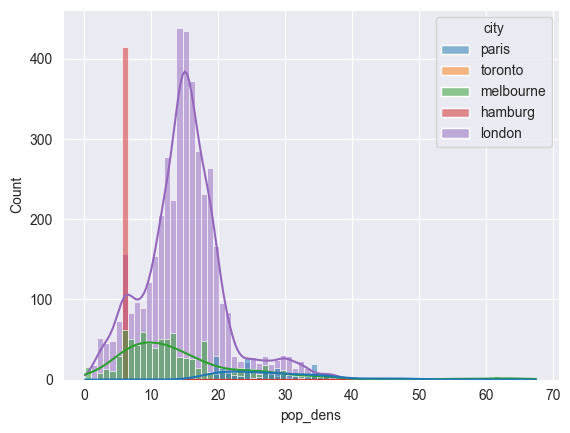

In [125]:
sns.histplot(df_reg, x='pop_dens', hue='city', kde=True)

the population density for hamburg seems to be everywhere the same. lets have a look at ti specifically

<Axes: ylabel='Density'>

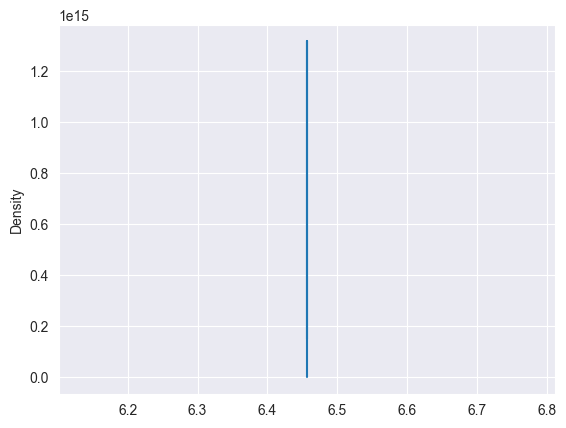

In [127]:
df_reg[df_reg.city == 'hamburg']['pop_dens'].plot(kind = 'kde')

<Axes: ylabel='Density'>

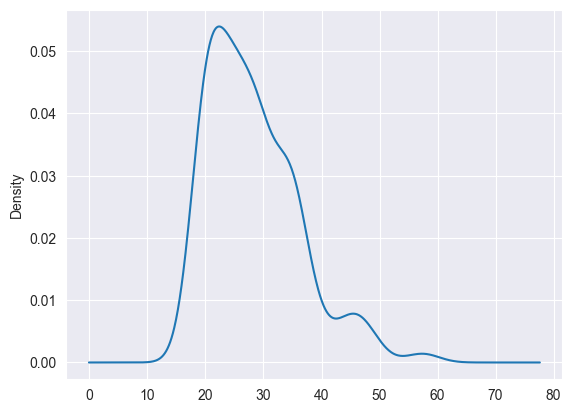

In [128]:
df_reg[df_reg.city == 'paris']['pop_dens'].plot(kind = 'kde')

Well hamburg is therefore not usable.

In [131]:
df_regLog = df_reg

<Axes: ylabel='Count'>

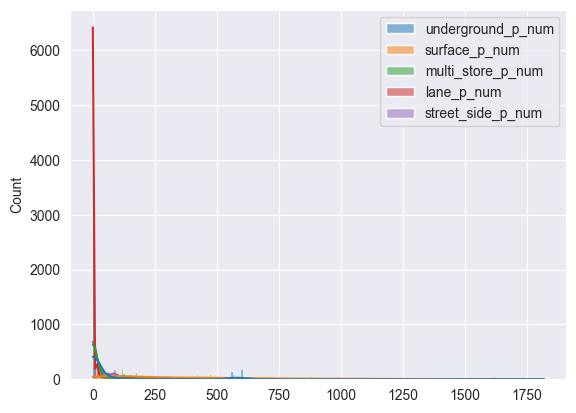

In [129]:
sns.histplot(df_reg[var_p], kde=True)

In [132]:
df_regLog[var_p] = np.log1p(df_reg[var_p])

<Axes: ylabel='Count'>

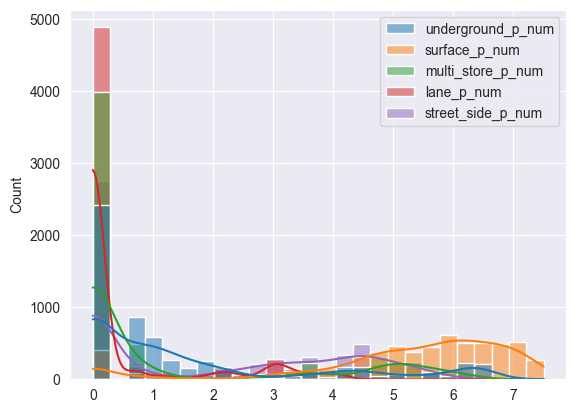

In [133]:
sns.histplot(df_regLog[var_p], kde=True)

* well whe have now a multimodal distribution.. dont know if that is a success .
Following strategy:
1. Perform a multilinear regression
2. check behaviour of residuals. -> Maybe this will help.
3. evtl check the effect of min_max scaling

#### Linear regression model

Explanation:

We do Linear multivariate regression

In [ ]:
lin_mod = LinearRegression()

X= df_regLog[var_p]
y= df_regLog.mean_flow

scores = cross_validate(lin_mod, X, y,
                      scoring=('r2', 'neg_root_mean_squared_error'), return_train_score=True)

In [ ]:
scores['test_neg_root_mean_squared_error'].mean() / y.mean()

Interpretation:
Well on aver the relative deviation of the mean is -80%

In [ ]:
scores['train_neg_root_mean_squared_error'].mean() / y.mean()

Interpretation:
Well on aver the relative deviation of the mean is -80%

In [ ]:
scores['test_r2'].mean()

Interpretation:

test: R2<0 means that our model is worse then the average
for the train it is slightly better but still horrible.

In [ ]:
scores['train_r2'].mean()

##### Hyothese testing

I follow [here](https://medium.com/nerd-for-tech/hypothesis-testing-on-linear-regression-c2a1799ba964)

We want to prove that there is a linear relation between the traffic flow and the parking vars. meaning that for all variables
$beta_i =_not 0$ (H1)

Therefore
$beta_i = 0$ (H0)

Lets use statsmodel bec it is bettwer for this kind of analysis

we reject H0 if beta i <.05
we fail to reject H0 if i>.05

p value is the probability that the relationsship between the target and the features is by pure chance. It must therefore be bellow .05 to be rejected.

In [ ]:
df_regLog.head()

In [136]:
var_pep = var_p + ['pop_dens']

In [138]:
df_regG = df_regLog.groupby('city')
p_coll = {}
c_coll = {}
r_coll = {}
for c, data in df_regG:

    if c in ['london', 'paris', 'melbourne']:
        var_i = var_pep
    else:
        var_i = var_p

    X_g = data[var_i]
    y_g = data['mean_flow']

    X_t = sm.add_constant(X_g)
    lm = sm.OLS(y_g, X_t).fit()

    p_coll[c] = lm.pvalues

    c_coll[c] = lm.params

    r_coll[c] = lm.rsquared

    print(f'Summary statistic for {c}'+'\n\n')
    print(lm.summary())



Summary statistic for hamburg


                            OLS Regression Results                            
Dep. Variable:              mean_flow   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     11.00
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           5.98e-10
Time:                        17:52:04   Log-Likelihood:                -2583.0
No. Observations:                 415   AIC:                             5178.
Df Residuals:                     409   BIC:                             5202.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const 

In [142]:
p_values = pd.DataFrame(p_coll, index=var_pep)
c_values = pd.DataFrame(c_coll, index=var_pep)
r_values = pd.Series(r_coll)


Text(0.5, 1.0, 'p_values for different cities ')

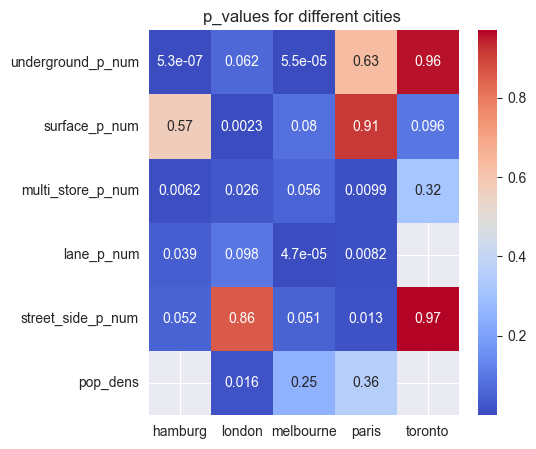

In [143]:
f, ax = plt.subplots(1, figsize=(5,5))
sns.heatmap(p_values, annot=True, cmap='coolwarm')
plt.title('p_values for different cities ')

Text(0.5, 1.0, 'Regression_coefficients for cities and parameters')

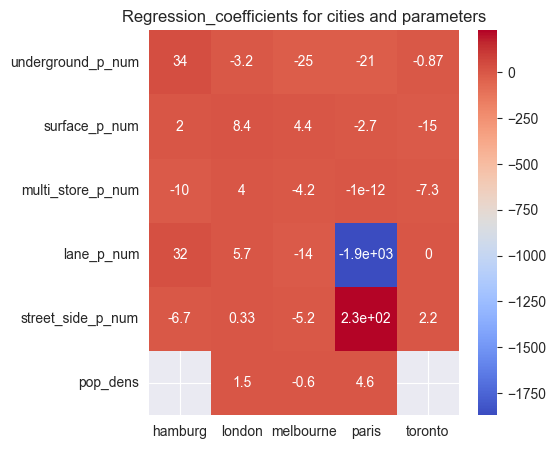

In [144]:
f, ax = plt.subplots(1, figsize=(5,5))
sns.heatmap(c_values, annot=True, cmap='coolwarm')
plt.title('Regression_coefficients for cities and parameters')

In [ ]:
r_values

# Disucssion
* the R2 is lower (delta=.001) however considering this is only one model run  it is OK.
* the variables lane_p_num is the only value that is significant >.05 and has a negative coefficient of -4961